In [1]:
# import
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Model, pipeline

import re
from sklearn.manifold import TSNE

c:\Users\lasse\miniconda3\envs\deep\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## setup device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  

cpu


In [3]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# set tokenizer padding token
tokenizer.pad_token = tokenizer.eos_token
# load out trained model
model = torch.load("model_20epoch.pt")
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [4]:
# use dataclass to create different datasets
class lyricsdataset(Dataset):
    def __init__(self, data_full, tokenizer, size, transform=None):
        self.size = size
        self.data_split = data_full
        self.token = tokenizer
        self.length = np.zeros((len(data_full),1))
        for i in range(len(data_full)):
            self.length[i] = len(re.findall(r'', data_full[i]))

        self.max_length = int(np.max(self.length))


    def __len__(self):
        return len(self.data_split)
    
    def __getitem__(self, idx):
        
        self.data_input = self.data_split[idx*self.size: (idx+1)*self.size]
        
        if len(self.data_input) < self.size:
            self.data_input = self.data_input + ['']*(10-len(self.data_input))
        
        return self.token(' '.join(self.data_input), padding="max_length", max_length=self.max_length,truncation = True,return_tensors="pt" )

# load data from file:
with open("xmas_lyrics_dlpl.txt", "r", encoding = "utf-8") as f:
    raw_data = f.readlines()

# create dataset with Dataset subclass
dataset = lyricsdataset(raw_data,tokenizer,50)


with open("pop_lyrics_dlpl.txt", "r", encoding = "utf-8") as f:
    raw_data_pop = f.readlines()

# create dataset with Dataset subclass
dataset_pop = lyricsdataset(raw_data_pop,tokenizer,50)

with open("metal_lyrics.txt", "r", encoding = "utf-8") as f:
    raw_data_pop = f.readlines()

# create dataset with Dataset subclass
dataset_metal = lyricsdataset(raw_data_pop,tokenizer,50)

In [5]:
embeddings_dict = {}
with open("emb_model/model.txt", 'r',encoding="utf8") as f:
    for line in f:
        try:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
        except:
           #there is some weird encoding in a few lines:
            values = line.split()
            word = values[0]
            print(word)



def find_closest_embeddings(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))

2
1
3
<dfn
<wbr
4
<rt
<ruby
5
1
6
33
7
8
1
<ref
<ref
<rt
<ruby
<rt
<ruby
<score


In [8]:
def txt_cleaner_embedding(line):
    """
    Take a lyric for a single song and removes unwanted parts and cleans the text
    """
    
    d = {
        r'\)' : '',
        r'\(' : '',
        ','   : '',
        '-'   : ' ',
        
    }

    for key, value in d.items():
        line = re.sub(key, value, line)


    return line

c:\Users\lasse\miniconda3\envs\deep\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\lasse\miniconda3\envs\deep\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'T-SNE plot of embedding')

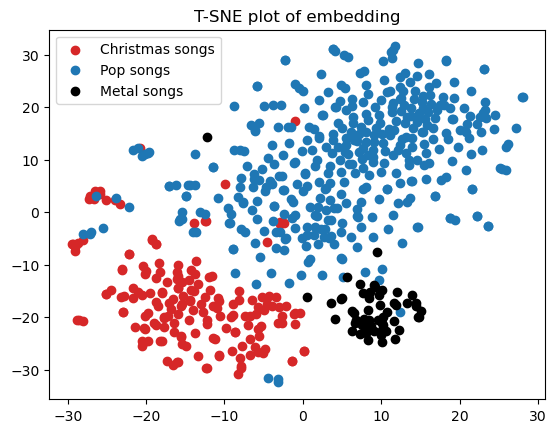

In [9]:
vector = []

## christmas songs
N_christmas_songs = 180

for song in range(N_christmas_songs):
    song_length = 0
    dataset.__getitem__(song)
    cristmassong = dataset.data_input
    vector_tot = 0
    for line in cristmassong:
        
        line=txt_cleaner_embedding(line)

        words = line.split()
        for word in words:
            try:
                #vector_tot[song] += embeddings_dict[word]
                vector_tot += embeddings_dict[word]
                song_length += 1
            except: 
                # some words are to weird
                continue
    
    #vector_tot[song] = vector_tot[song]/song_length
    vector.append(vector_tot/song_length)


### POP SONGS

N_pop_songs = 400

for song in range(N_pop_songs):
    song_length = 0
    dataset_pop.__getitem__(song)
    cristmassong = dataset_pop.data_input
    vector_tot = 0
    for line in cristmassong:
        
        line=txt_cleaner_embedding(line)

        words = line.split()
        for word in words:
            try:
                #vector_tot[song] += embeddings_dict[word]
                vector_tot += embeddings_dict[word]
                song_length += 1
            except: 
                # some words are to weird
                continue
    
    #vector_tot[song] = vector_tot[song]/song_length
    vector.append(vector_tot/song_length)


## Metal songs

N_metal_songs = 55

for song in range(N_metal_songs):
    song_length = 0
    dataset_metal.__getitem__(song)
    cristmassong = dataset_metal.data_input
    vector_tot = 0
    for line in cristmassong:
        
        line=txt_cleaner_embedding(line)

        words = line.split()
        for word in words:
            try:
                #vector_tot[song] += embeddings_dict[word]
                vector_tot += embeddings_dict[word]
                song_length += 1
            except: 
                # some words are to weird
                continue
    
    #vector_tot[song] = vector_tot[song]/song_length
    vector.append(vector_tot/song_length)

#print(vector)
tsne = TSNE()
#print([vector_tot[0],vector_tot[1]])
pro = tsne.fit_transform(vector)


plt.scatter(pro[:N_christmas_songs,0],pro[:N_christmas_songs,1], c = "tab:red", label = "Christmas songs")
plt.scatter(pro[N_christmas_songs:N_christmas_songs+ N_pop_songs,0],pro[N_christmas_songs:N_christmas_songs+ N_pop_songs,1], c = "tab:blue", label = "Pop songs")
plt.scatter(pro[N_christmas_songs+ N_pop_songs:N_christmas_songs+ N_pop_songs+N_metal_songs,0],pro[N_christmas_songs+ N_pop_songs:N_christmas_songs+ N_pop_songs+N_metal_songs,1], c = "black", label = "Metal songs")
plt.legend()
plt.title("T-SNE plot of embedding")

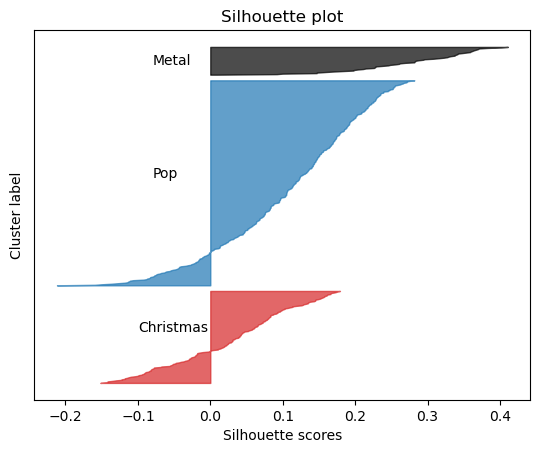

In [10]:
#vector is embedding first 100 is christmas from 100 to final pop songs
# i will now try to do silouhet analysis on the freakin data
from sklearn.metrics import silhouette_samples

# create the labels fast
lables = np.concatenate([np.zeros(N_christmas_songs), np.ones(N_pop_songs), np.ones(N_metal_songs)+1])

sil_scores = silhouette_samples(vector, lables)

fig, ax1 = plt.subplots()

christmas_silhouette_values = sil_scores[:N_christmas_songs]
pop_silhouette_values = sil_scores[N_christmas_songs:N_christmas_songs+N_pop_songs]
metal_silhouette_values = sil_scores[N_christmas_songs+N_pop_songs:]

ax1.fill_betweenx(
            np.arange(0, N_christmas_songs),
            0,
            sorted(christmas_silhouette_values),
            facecolor="tab:red",
            edgecolor="tab:red",
            alpha=0.7,
        )
ax1.text(-0.1, 100, "Christmas")

ax1.fill_betweenx(
            np.arange(N_christmas_songs+10, N_christmas_songs + N_pop_songs+10),
            0,
            sorted(pop_silhouette_values),
            facecolor="tab:blue",
            edgecolor="tab:blue",
            alpha=0.7,
        )
ax1.text(-0.08, 400, "Pop")

ax1.fill_betweenx(
            np.arange(N_christmas_songs + N_pop_songs+20, N_christmas_songs + N_pop_songs + N_metal_songs+20),
            0,
            sorted(metal_silhouette_values),
            facecolor="black",
            edgecolor="black",
            alpha=0.7,
        )
        
ax1.text(-0.08, 620, "Metal")

ax1.set_yticks([])  # Clear the yaxis labels / ticks'
ax1.set_title("Silhouette plot")
ax1.set_xlabel("Silhouette scores")
ax1.set_ylabel("Cluster label")

plt.savefig("Silhouette_plot.svg")
plt.show()

In [11]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# set tokenizer padding token
tokenizer.pad_token = tokenizer.eos_token
# load out trained model
model = torch.load("model_20epoch.pt")
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [12]:
## add christmas songs to vectors list

# get prompts
N_prompts = 10
prompts = []
with open("christmas_words.txt") as f:
    prompt_lines = f.readlines()



pipe = pipeline("text-generation", model = model, tokenizer=tokenizer)
sent = 1
for i in range(N_prompts):
    prompt = np.random.choice(prompt_lines).replace("\n", "")
    gen_song = pipe(prompt, max_length=150, num_return_sequences=sent, temperature=1, no_repeat_ngram_size = 4)
    for i in range(sent):
        print(f"song {i}")
        print(gen_song[i]["generated_text"])
        print()


    for i in range(sent):    
        cristmassong = gen_song[i]["generated_text"].split("\n")
        vector_tot = 0
        for line in cristmassong:
            line=txt_cleaner_embedding(line)

            words = line.split()
            for word in words:
                try:
                    #vector_tot[song] += embeddings_dict[word]
                    vector_tot += embeddings_dict[word]
                    song_length += 1
                except: 
                    # some words are to weird
                    continue

        #vector_tot[song] = vector_tot[song]/song_length
        vector.append(vector_tot/song_length)
#print(vector)
tsne = TSNE()
#print([vector_tot[0],vector_tot[1]])
pro = tsne.fit_transform(vector)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


song 0
trees burning low
 snow is snowing
 ground is icicles form
 cheer

 Overeating, merry greeting
 From relatives you don't know
 But for Christmas, do you?
 Ove-o-a-feisties
 Ovelly
 Christ is heaven
 But heaven's night
 When ol' Santa gets into town
 He won't make a list
 And before Santa gets stuck in heavenly peace
 Oh, star at the show
 "Fear."
 Oveoh-a-o-ding-a-do-a
 Ovele, hey and away
 He wonin' when the snow's the most
 Ove
 Born a King on Bethlehem's plain
 Did you know that



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


song 0
ice Come they told me (pa-rum pum pum pining pum painted painted pittens
 I'm here with been
 Been a year over
 But now I am longing one thing
 Here comes that songs
 I listen
 To hear my songs employ
 To hear me in my ear
 I listen for the thud of thе sе twelfth
 So get ready, sing out loud so we can all hear
 To hear the songs employ
 I listen and the thе thе thud of
 Have a holly and in the winter snow
 I'm happy on
 To hear those holiday jingle bells
 When I'm near to us
 To hear all
 When I hear those jingle bells



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


song 0
candycanes burning low
 Let me see, I'll make amends
 (Christmas)
 The Christmas snow's coming down
 (Christmas pheasants, Christmas)
 (Christmas time is here
 (Christmas songs
 (Christmas comes)
 ( Christmas time is here (Christmas time (Christmas time)
 (Let me know, I know)
 Baby, please come home
 They singing "Deck the Halls"
 But it's not like Christmas at all
 'Cause I remember when I got your love
 (Christmas over) Can it be Christmas time
 (If we just make it to Christmas time
 Every year I dream it gave
 (Christmas to me)
 Santa's coming home
 You're all



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


song 0
wreath, if you can see
 Every year this Christmas tree
 Think thy leaves are so unchanging
 O Tender and here
 Was born
 And laid within a manger
 Upon this blessed morn
 Did you know that your love has come?
?
 Did you ever think of us?
 Is it?
 Is the season to be late?
 When Did you know something bright
 But your lips employ me?
 DidYou know that your lips are delicious
 O Tannen?
 Did your know
 That our lips employ?
 (Toa-long)
 (O T hey)
 Did you think of us
 Is it wrong?
 When you're skating in the park
 You're skating



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


song 0
elves burning low
 You're here with me
 It's that time of the year
 When I'm near to us
 You're all I need
 Underneath the tree
 I don't wanna be alone
 I know when I see the presents underneath falling in the room
 I don wanna be alone with me
 I see the children play outside, like angels in the snow
 While mom and daddy share a kiss under the mistletoe
 And we'll kiss by candlelight
 Wantside in the kitchen while embers glow
 When I know, by goshin' me
 It feels like Christmas time
 Those Christmas time
 (All these things and more, darling)
 (All your things and more (All these



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


song 0
festive
 Said I was love, my true love sent to me
 The Christmas snow is white on me's white on me
 To me, my true Love and songs employ
 I'm dyin' to say, oh how I love you
 You're workin' towards me now
 But I'm amin' towards said, oh how
 To love me
 From ear to ear
 To ear me know when I got em'hey
 To hear
 To hear the choir sing
 To hear those sleigh bells in the snow
 I'm gonna get inside
 I'm hanging all the stockings by the Christmas snow
 Oh-a-do
 Here comes the jackpot question in advance
 What am you doing?




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


song 0
candycanes
 Laeti triumphantes
 Venite, venite in Bethlehem
 Lamb
 O come, here comes Christ
 Right down Santa Claus Lane
 He's got a bag that's so very own
 Have a holly-go-round
 It's that time of year when you all want to hear
 A friend, if you're not here with me
 And when those Christmas lights
 Wish you a Merry Christmas bright
 Have a Christmas time
 To hear, a night when you're not in town
 Later on, we'll
 Have a little snow and snow
 And, and snow
 



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


song 0
wreath, if you could see
 I'm riding in the snow
 I'm driving home for Christmas
 Well, I'm moving down that line
 Saying, "It's so long
 To let you know, I can't quite escape
 When I see the snowman walking 'cross the room
 "Let It Snow" is blasting out
 But I won't sing this song
 To someone special
 Last Christmas time but I got Santa's got a toy on Christmas time
 I got so much love
 Can't be alone
 I all those chandeliers of snow
 When I'maha
 And when I don't
 'Cause I remember when I see the children play
 But it's not like Christmas time
 To let



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


song 0
gifts snow
 You are the jingle bell, jingle bell time
 It's the jingle hop
 When you sing your heart
 It's Christmas time
 I don't know if there'll be snow
 But have a cup of cheer
 Have a holly and jolly Christmas time
 When you walk down the street
 Say Hello to friends you know
 And everyone you meet
 Oh, ho, with a holly
 And you know, "Baby, it's Christmas time but some time
 WhenYou melt out the street
 Come down the chimney, stuck in the snow
 You make it feel like a yum yummy snow
 Have a yum jolly Christmas song
 And in here
 On while the

song 0
elves are hung where you can see
 Every couple tries to stop
 Everybody's waiting for the man with the bag
 'Cause Christmas is coming again
 He's got a sleigh full, it's not like a lot like you could pout
 Everybody's wait for the manWith the bag
 So come on, let's go
 Let's go below zero and hide from the sun
 I'll love you forever where we'll have some fun
 Yes, let's hit the North Pole and live happily
 Please don't cry no 

c:\Users\lasse\miniconda3\envs\deep\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\lasse\miniconda3\envs\deep\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'T-SNE plot of embedding')

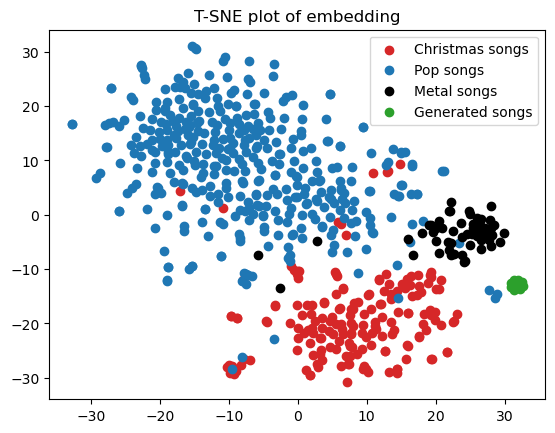

In [13]:
plt.scatter(pro[:N_christmas_songs,0],pro[:N_christmas_songs,1], c = "tab:red", label = "Christmas songs")
plt.scatter(pro[N_christmas_songs:N_christmas_songs+ N_pop_songs,0],pro[N_christmas_songs:N_christmas_songs+ N_pop_songs,1], c = "tab:blue", label = "Pop songs")
plt.scatter(pro[N_christmas_songs+ N_pop_songs:N_christmas_songs+ N_pop_songs+N_metal_songs,0],pro[N_christmas_songs+ N_pop_songs:N_christmas_songs+ N_pop_songs+N_metal_songs,1], c = "black", label = "Metal songs")
plt.scatter(pro[N_christmas_songs+ N_pop_songs+N_metal_songs:,0],pro[N_christmas_songs+ N_pop_songs+N_metal_songs:,1], c = "tab:green", label = "Generated songs")
plt.legend()
plt.title("T-SNE plot of embedding")
#plt.savefig("t_sne.svg")

In [14]:
lables_new = np.concatenate([lables, np.zeros(sent*N_prompts)])

sil_scores_new = silhouette_samples(vector, lables_new)
sil_scores_new[N_christmas_songs+ N_pop_songs+N_metal_songs:]
print(f'The silouhet scores for the gererated songs are:{sil_scores_new[N_christmas_songs+ N_pop_songs+N_metal_songs:]}')

The silouhet scores for the gererated songs are:[-0.12420645 -0.11876717 -0.10405722 -0.11974921 -0.12441606 -0.11788403
 -0.11031418 -0.11707893 -0.1099142  -0.11822408]
